# **Feature Engineering**

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# Set pandas display options for better visibility of data
pd.set_option('display.max_colwidth', None)  # Show full column width
pd.set_option('display.max_rows', None)      # Show all rows in output
pd.set_option('display.max_columns', None)   # Show all columns in output

---
## Load Data

In [2]:
input = '../data/clean-data/flats-house-cleaned-v1.csv'
output = '../data/clean-data/flats-house-cleaned-v2.csv'

df = pd.read_csv(input)
df.head(2)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,emaar mgf palm hills,sector 77,1.50,12744.0,1177.0,Super Built up area 1450(134.71 sq.m.)Carpet area: 1177 sq.ft. (109.35 sq.m.),3,3,3,not available,4.0,North-East,1 to 5 Year Old,"['Sapphire 83 Mall', 'Dwarka Expressway', 'Sohna Road', 'Narayana e Techno School', 'DPG Institute of Technology', 'Medeor Hospital, Manesar', 'Indira Gandhi International Airport', 'IMT Manesar', 'Hyatt Regency Gurgaon', 'De Adventure Park']","['10 Wardrobe', '1 Water Purifier', '5 Fan', '2 Geyser', '1 Stove', '33 Light', '4 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Recently Renovated', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Natural Light', 'Internet/wi-fi connectivity', 'Airy Rooms', 'Spacious Interiors', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Club house / Community Center', 'Water softening plant']"
1,flat,raheja vedaanta,sector 108,0.85,4637.0,1833.0,Super Built up area 1833(170.29 sq.m.)Built Up area: 1500 sq.ft. (139.35 sq.m.)Carpet area: 1350 sq.ft. (125.42 sq.m.),3,3,2,servant room,2.0,North-East,1 to 5 Year Old,NaN,"['7 Fan', '16 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Power Back-up', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Swimming Pool', 'Maintenance Staff', 'Park', 'Security Personnel', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center', 'Rain Water Harvesting']"


In [3]:
# Count the number of duplicate rows in the DataFrame
df.duplicated().sum()

np.int64(122)


## Focus Areas

The following features will be the focus of our analysis:

- **areaWithType**: This feature provides information about the area of the property, including different types such as Super Built up area, Built Up area, and Carpet area.

- **additionalRoom**: This feature indicates the presence of additional rooms in the property, such as servant rooms, study rooms, and pooja rooms.

- **agePossession**: This feature describes the age of the property and the possession status, which can affect the property's value and desirability.

- **furnishDetails**: This feature contains details about the furnishings available in the property, which can influence buyer decisions.

- **features**: This feature lists various amenities and features of the property, such as security systems, parking facilities, and recreational areas.






---
## 1. areaWithType

In [4]:
df.sample(5)[['price','area','areaWithType']]

,price,area,areaWithType
1001,1.25,1490.0,Super Built up area 1490(138.43 sq.m.)Built Up area: 1058 sq.ft. (98.29 sq.m.)Carpet area: 863.91 sq.ft. (80.26 sq.m.)
2056,0.95,1450.0,Carpet area: 1450 (134.71 sq.m.)
1416,1.43,1609.0,Super Built up area 1608(149.39 sq.m.)
2915,0.26,576.0,Super Built up area 576(53.51 sq.m.)
3500,1.05,990.0,Built Up area: 97 Carpet area: 92 sq.m.


In [5]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [6]:
# This function extracts the Built Up area or Carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [7]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [8]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [9]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2342,2.40,flat,2660.0,Super Built up area 2660(247.12 sq.m.),2660.0,NaN,NaN
1340,0.43,flat,1364.0,Super Built up area 1364(126.72 sq.m.)Built Up area: 1300 sq.ft. (120.77 sq.m.)Carpet area: 1020 sq.ft. (94.76 sq.m.),1364.0,1300.0,1020.0
446,0.71,flat,1439.0,Carpet area: 1436 (133.41 sq.m.),NaN,NaN,1436.0
1841,0.37,house,360.0,Plot area 360(33.45 sq.m.),NaN,NaN,NaN
3069,3.05,flat,3156.0,Super Built up area 3156(293.2 sq.m.),3156.0,NaN,NaN


In [10]:
df.duplicated().sum()

np.int64(122)

In [11]:
# This line retrieves the shape of the DataFrame that contains rows where 
# 'super_built_up_area', 'built_up_area', and 'carpet_area' are all not null.

df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape

(534, 7)

In [12]:
# This line filters the DataFrame to include only rows where the 'areaWithType' column contains the word 'Plot'.
# It then selects specific columns to display: 'price', 'property_type', 'area', 'areaWithType', 
# 'super_built_up_area', 'built_up_area', and 'carpet_area', and retrieves the first 5 entries of the resulting DataFrame.

df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].head(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
10,0.80,house,900.0,Plot area 900(83.61 sq.m.)Built Up area: 900 sq.ft. (83.61 sq.m.),NaN,900.0,NaN
22,6.00,house,190.0,Plot area 190(17.65 sq.m.)Carpet area: 1600 sq.ft. (148.64 sq.m.),NaN,NaN,1600.0
23,3.69,house,1557.0,Plot area 173(144.65 sq.m.),NaN,NaN,NaN
24,2.75,house,154.0,Plot area 154(14.31 sq.m.)Carpet area: 1650 sq.ft. (153.29 sq.m.),NaN,NaN,1650.0
25,12.50,house,3240.0,Plot area 360(301.01 sq.m.),NaN,NaN,NaN


In [13]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2616
carpet_area            1859
dtype: int64

In [14]:
# Create a DataFrame containing rows where 'super_built_up_area', 'built_up_area', and 'carpet_area' are all null.
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

In [15]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
23,3.69,house,1557.0,Plot area 173(144.65 sq.m.),NaN,NaN,NaN
25,12.50,house,3240.0,Plot area 360(301.01 sq.m.),NaN,NaN,NaN
28,9.50,house,4071.0,Plot area 500(418.06 sq.m.),NaN,NaN,NaN
48,2.30,house,1350.0,Plot area 150(125.42 sq.m.),NaN,NaN,NaN
49,12.25,house,5850.0,Plot area 5850(543.48 sq.m.),NaN,NaN,NaN


In [16]:
# Retrieve the index of rows in the DataFrame where 'super_built_up_area', 'built_up_area', and 'carpet_area' are all null.

all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index
all_nan_index

Index([  23,   25,   28,   48,   49,   55,   68,   69,   74,   87,
       ...
       3743, 3746, 3749, 3758, 3760, 3763, 3765, 3773, 3775, 3792],
      dtype='int64', length=546)

In [17]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [18]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

# Update the original dataframe
#gurgaon_properties.update(filtered_rows)

In [19]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
23,3.69,house,1557.0,Plot area 173(144.65 sq.m.),NaN,173.0,NaN
25,12.50,house,3240.0,Plot area 360(301.01 sq.m.),NaN,360.0,NaN
28,9.50,house,4071.0,Plot area 500(418.06 sq.m.),NaN,500.0,NaN
48,2.30,house,1350.0,Plot area 150(125.42 sq.m.),NaN,150.0,NaN
49,12.25,house,5850.0,Plot area 5850(543.48 sq.m.),NaN,5850.0,NaN


In [20]:
def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [21]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [22]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
23,3.69,house,1557.0,Plot area 173(144.65 sq.m.),NaN,1557.0,NaN
25,12.50,house,3240.0,Plot area 360(301.01 sq.m.),NaN,3240.0,NaN
28,9.50,house,4071.0,Plot area 500(418.06 sq.m.),NaN,500.0,NaN
48,2.30,house,1350.0,Plot area 150(125.42 sq.m.),NaN,1350.0,NaN
49,12.25,house,5850.0,Plot area 5850(543.48 sq.m.),NaN,5850.0,NaN


In [23]:
# update the original dataframe
df.update(all_nan_df)

In [24]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2070
carpet_area            1859
dtype: int64

In [25]:
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area
0,flat,emaar mgf palm hills,sector 77,1.5,12744.0,1177.0,Super Built up area 1450(134.71 sq.m.)Carpet area: 1177 sq.ft. (109.35 sq.m.),3,3,3,not available,4.0,North-East,1 to 5 Year Old,"['Sapphire 83 Mall', 'Dwarka Expressway', 'Sohna Road', 'Narayana e Techno School', 'DPG Institute of Technology', 'Medeor Hospital, Manesar', 'Indira Gandhi International Airport', 'IMT Manesar', 'Hyatt Regency Gurgaon', 'De Adventure Park']","['10 Wardrobe', '1 Water Purifier', '5 Fan', '2 Geyser', '1 Stove', '33 Light', '4 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Recently Renovated', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Natural Light', 'Internet/wi-fi connectivity', 'Airy Rooms', 'Spacious Interiors', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Club house / Community Center', 'Water softening plant']",1450.0,NaN,1177.0


---
## 2.additionalRoom

In [26]:
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1587
servant room                                      705
study room                                        250
others                                            225
pooja room                                        165
store room                                         99
study room,servant room                            99
pooja room,servant room                            82
pooja room,study room,servant room,store room      72
servant room,others                                60
pooja room,study room,servant room                 55
pooja room,study room,servant room,others          54
servant room,pooja room                            38
servant room,store room                            33
study room,others                                  29
pooja room,study room                              22
pooja room,others                                  17
pooja room,store room                              15
pooja room,st

In [27]:
# additional room
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

# Populate the new columns based on the "additionalRoom" column
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [28]:
df.sample(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
2595,servant room,0,1,0,0,0
3671,servant room,0,1,0,0,0
3802,others,0,0,0,0,1
804,"study room,servant room",1,1,0,0,0
3106,not available,0,0,0,0,0


In [29]:
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,emaar mgf palm hills,sector 77,1.5,12744.0,1177.0,Super Built up area 1450(134.71 sq.m.)Carpet area: 1177 sq.ft. (109.35 sq.m.),3,3,3,not available,4.0,North-East,1 to 5 Year Old,"['Sapphire 83 Mall', 'Dwarka Expressway', 'Sohna Road', 'Narayana e Techno School', 'DPG Institute of Technology', 'Medeor Hospital, Manesar', 'Indira Gandhi International Airport', 'IMT Manesar', 'Hyatt Regency Gurgaon', 'De Adventure Park']","['10 Wardrobe', '1 Water Purifier', '5 Fan', '2 Geyser', '1 Stove', '33 Light', '4 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Recently Renovated', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Natural Light', 'Internet/wi-fi connectivity', 'Airy Rooms', 'Spacious Interiors', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Club house / Community Center', 'Water softening plant']",1450.0,NaN,1177.0,0,0,0,0,0


---
## 3.agePossession

This section categorizes the age of a property based on its description in the 'agePossession' column. 

Properties are sorted into the following groups:-

- `New Property`: for properties less than a year old.

- `Relatively New`: for properties aged between 1 to 5 years.

- `Moderately Old`: for properties aged between 5 to 10 years.

- `Old Property`: for properties older than 10 years.

- `Under Construction`: for properties that are still being built or have future dates mentioned.

If the age cannot be determined, it is labeled as `Undefined`.

This categorization aids in understanding the age distribution of properties in the dataset.





In [30]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Oct 2024                 8
Jan 2024                 8
Aug 2023                 7
Jun 2024                 7
Dec 2025                 7
Nov 2023                 5
Sep 2023                 4
Jul 2024                 4
By 2025                  4
Aug 2024                 4
Oct 2023                 4
Nov 2024                 3
Jan 2025                 3
Feb 2024                 3
May 2024                 3
Jul 2025                 2
Apr 2026                 2
Jun 2027                 2
Mar 2025                 2
Sep 2025                 2
Aug 2025                 2
Jan 2026                 2
Oct 2025                 2
Dec 2026      

In [31]:
# Function to categorize the age of possession of a property based on the provided value.
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"  # Return "Undefined" for NaN values
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"  # Categorize as "New Property" for recent entries
    if "1 to 5 Year Old" in value:
        return "Relatively New"  # Categorize as "Relatively New" for properties aged 1 to 5 years
    if "5 to 10 Year Old" in value:
        return "Moderately Old"  # Categorize as "Moderately Old" for properties aged 5 to 10 years
    if "10+ Year Old" in value:
        return "Old Property"  # Categorize as "Old Property" for properties older than 10 years
    if "Under Construction" in value or "By" in value:
        return "Under Construction"  # Categorize as "Under Construction" for relevant entries
    try:
        # For entries like 'May 2024', check if the last part is a year
        int(value.split(" ")[-1])  # Attempt to convert the last part to an integer
        return "Under Construction"  # If successful, categorize as "Under Construction"
    except:
        return "Undefined"  # Return "Undefined" for any other cases

In [32]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [33]:
df['agePossession'].value_counts()

agePossession
Relatively New        1676
New Property           626
Moderately Old         575
Undefined              333
Old Property           310
Under Construction     283
Name: count, dtype: int64

---
## 4.furnishDetails


We group furnishing type to each property in the dataset using KMeans clustering.

- The KMeans algorithm groups properties based on their features, allowing for the identification of similar properties.

- The number of clusters is set to 3, which corresponds to the following furnishing types:

  0 -> unfurnished

  1 -> semifurnished

  2 -> furnished

In [34]:
df.sample(5)[['furnishDetails','features']]

,furnishDetails,features
655,NaN,"['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
3586,"['6 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Water purifier', 'Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Internet/wi-fi connectivity', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
1565,"['1 Water Purifier', '1 Fridge', '4 Fan', '1 Exhaust Fan', '1 Dining Table', '1 Stove', '4 Light', '1 Chimney', '1 Curtains', '1 Modular Kitchen', '1 Bed', '2 Wardrobe', '1 Sofa', 'No AC', 'No Geyser', 'No Microwave', 'No TV', 'No Washing Machine']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']"
3108,"['2 Wardrobe', '4 Fan', '1 Exhaust Fan', '2 Geyser', '10 Light', '1 Modular Kitchen', '1 Chimney', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
569,"['3 Wardrobe', '5 Fan', '1 Exhaust Fan', '3 Geyser', '5 Light', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Water purifier', 'Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"


In [35]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]


In [36]:
furnishings_df.shape

(3803, 19)

In [37]:
furnishings_df.drop(columns=['furnishDetails'],inplace=True)

/tmp/ipykernel_13418/114705885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=['furnishDetails'],inplace=True)


In [38]:
furnishings_df.sample(5)

,Fan,AC,Modular Kitchen,Geyser,TV,Exhaust Fan,Washing Machine,Bed,Light,Stove,Wardrobe,Microwave,Sofa,Fridge,Chimney,Water Purifier,Curtains,Dining Table
836,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3632,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
2466,6,0,1,0,0,1,0,0,10,0,4,0,0,0,1,0,0,0
2205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2977,4,0,0,0,0,0,0,0,5,0,2,0,0,0,0,0,0,0


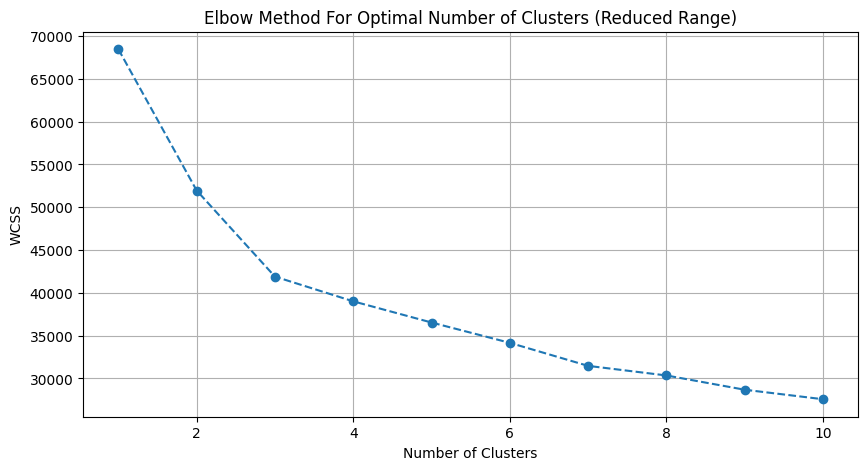

In [39]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [40]:

n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [41]:
df = df.iloc[:,:-18]

In [42]:
df['furnishing_type'] = cluster_assignments

In [43]:
df.columns

Index(['property_type', 'society', 'sector', 'price', 'price_per_sqft', 'area',
       'areaWithType', 'bedRoom', 'bathroom', 'balcony', 'additionalRoom',
       'floorNum', 'facing', 'agePossession', 'nearbyLocations',
       'furnishDetails', 'features', 'super_built_up_area', 'built_up_area',
       'carpet_area', 'study room', 'servant room', 'store room', 'pooja room',
       'others', 'furnishing_type'],
      dtype='object')

In [44]:
df.sample(5)[['furnishDetails','furnishing_type']]

,furnishDetails,furnishing_type
920,"['1 Wardrobe', '1 Stove', '1 Chimney', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine', 'No Water Purifier']",0
235,"['1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",0
2866,"['1 Fan', '1 Light', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Geyser', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",0
2226,"['5 Wardrobe', '8 Fan', '1 Exhaust Fan', '20 Light', '5 AC', '1 Modular Kitchen', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Geyser', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",2
1129,"['15 Light', '5 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",0


---
## 5.features

In [45]:
df[['society','features']].sample(5)

,society,features
1171,sare crescent parc,"['Intercom Facility', 'Lift(s)', 'Park']"
2952,emaar mgf emerald floors premier,"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']"
3456,sushant lok 1 builder floors,"['Feng Shui / Vaastu Compliant', 'High Ceiling Height', 'Maintenance Staff', 'Water Storage', 'Park', 'Recently Renovated', 'Visitor Parking', 'Natural Light', 'Waste Disposal']"
2490,tulip violet,"['Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
714,indiabulls centrum park,"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']"


In [46]:
df['features'].isnull().sum()

np.int64(635)

In [47]:
# imputing features missing value with apparments features
app_df = pd.read_csv('../data/scrap-data/appartments.csv')
app_df.head(1)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Palam Vihar', 'Park Hospital', 'Gurgaon Railway Station']","{'Bajghera Road': '800 Meter', 'Palam Vihar Halt': '2.5 KM', 'DPSG Palam Vihar': '3.1 KM', 'Park Hospital': '3.1 KM', 'Gurgaon Railway Station': '4.9 KM', 'The NorthCap University': '5.4 KM', 'Dwarka Expy': '1.2 KM', 'Hyatt Place Gurgaon Udyog Vihar': '7.7 KM', 'Dwarka Sector 21, Metro Station': '7.2 KM', 'Pacific D21 Mall': '7.4 KM', 'Indira Gandhi International Airport': '14.7 KM', 'Hamoni Golf Camp': '6.2 KM', 'Fun N Food Waterpark': '8.8 KM', 'Accenture DDC5': '9 KM'}",https://www.99acres.com/smartworld-one-dxp-sector-113-gurgaon-npxid-r400415,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,370 sq.ft.', 'price-range': '₹ 2 - 2.4 Cr'}, '3 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,850 - 2,050 sq.ft.', 'price-range': '₹ 2.25 - 3.59 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '2,600 sq.ft.', 'price-range': '₹ 3.24 - 4.56 Cr'}}","['Swimming Pool', 'Salon', 'Restaurant', 'Spa', 'Cafeteria', 'Sun Deck', '24x7 Security', 'Club House', 'Gated Community']"


In [48]:
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [49]:
temp_df = df[df['features'].isnull()]

In [50]:
temp_df.shape

(635, 26)

In [51]:
# Merging the temporary DataFrame with the app_df to retrieve TopFacilities based on society names
x = temp_df.merge(app_df, left_on='society', right_on='PropertyName', how='left')['TopFacilities']
df.loc[temp_df.index,'features'] = x.values

In [52]:
df['features'].isnull().sum()

np.int64(481)

In [53]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [54]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
1481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
872,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3524,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3537,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
3773,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0


In [55]:
features_binary_df.shape

(3803, 130)

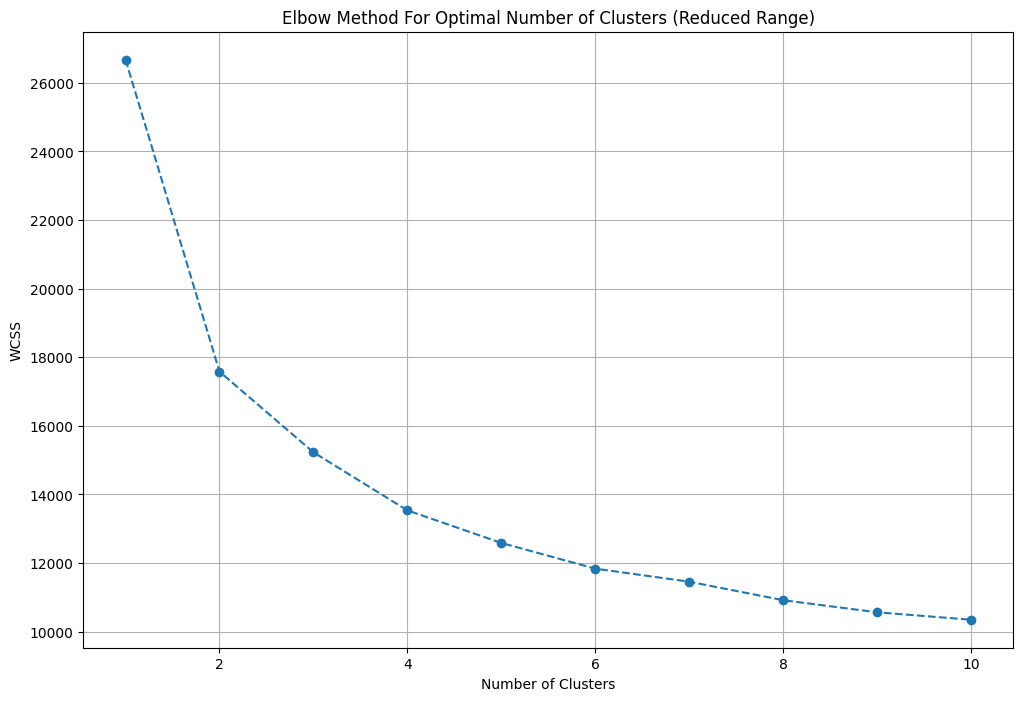

In [56]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

- The k-means clustering algorithm has proven to be ineffective in this scenario. The primary reason for this failure is that the algorithm is not able to identify the desired clusters for grouping the features effectively. 

- This can occur due to the high dimensionality of the feature space, which can lead to poor cluster separation and misclassification. Additionally, the inherent nature of k-means, which relies on the mean of the clusters, may not capture the underlying structure of the data accurately. 

- As a result, we will explore alternative approaches that may provide better clustering performance and more meaningful groupings of the features. These methods will be better suited to handle the complexities of our dataset and yield more insightful results.44

- Now we will use luxury score 

In [57]:
#With the help of GPT ,  I have manually Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)


In [58]:
df['luxury_score'] = luxury_score

In [59]:
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
0,flat,emaar mgf palm hills,sector 77,1.5,12744.0,1177.0,Super Built up area 1450(134.71 sq.m.)Carpet area: 1177 sq.ft. (109.35 sq.m.),3,3,3,not available,4.0,North-East,Relatively New,"['Sapphire 83 Mall', 'Dwarka Expressway', 'Sohna Road', 'Narayana e Techno School', 'DPG Institute of Technology', 'Medeor Hospital, Manesar', 'Indira Gandhi International Airport', 'IMT Manesar', 'Hyatt Regency Gurgaon', 'De Adventure Park']","['10 Wardrobe', '1 Water Purifier', '5 Fan', '2 Geyser', '1 Stove', '33 Light', '4 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Recently Renovated', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Natural Light', 'Internet/wi-fi connectivity', 'Airy Rooms', 'Spacious Interiors', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Club house / Community Center', 'Water softening plant']",1450.0,NaN,1177.0,0,0,0,0,0,2,"[Security / Fire Alarm, Feng Shui / Vaastu Compliant, Lift(s), Maintenance Staff, Water Storage, Recently Renovated, Piped-gas, Visitor Parking, Swimming Pool, Park, Natural Light, Internet/wi-fi connectivity, Airy Rooms, Spacious Interiors, Shopping Centre, Fitness Centre / GYM, Waste Disposal, Club house / Community Center, Water softening plant]",97


In [60]:
# Dropping unnecessary columns from the DataFrame to clean up the dataset.
# The columns being removed are: nearbyLocations, furnishDetails, features, features_list, and additionalRoom.

df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [61]:
df.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
2372,flat,m3m heights,sector 65,2.29,15980.0,1433.0,Carpet area: 1433 (133.13 sq.m.),2,2,3,8.0,NaN,Under Construction,NaN,NaN,1433.000000,1,0,0,0,0,0,15
1485,flat,rof ananda,sector 95,0.38,6919.0,549.0,Carpet area: 549.17 (51.02 sq.m.),2,2,1,4.0,NaN,New Property,NaN,NaN,549.174178,0,0,0,0,0,0,0
887,flat,antriksh heights,sector 84,1.02,4868.0,2095.0,Super Built up area 2095(194.63 sq.m.),4,4,3+,11.0,North,Relatively New,2095.0,NaN,NaN,0,1,0,1,0,0,99
2161,flat,supertech araville,sector 79,1.45,7455.0,1945.0,Carpet area: 1945 (180.7 sq.m.),3,3,3,3.0,North,Relatively New,NaN,NaN,1945.000000,0,0,0,0,0,0,0
850,flat,dlf new town heights,sector 86,1.26,6113.0,2061.0,Super Built up area 1930(179.3 sq.m.),3,3,3,5.0,West,Moderately Old,1930.0,NaN,NaN,0,1,0,0,1,0,113


In [62]:
df.shape

(3803, 23)

In [63]:
df.to_csv(output,index=False)

**End**